# Chromosome classification

Karyotyping is the process by which photographs of chromosomes are taken in order to determine the chromosome complement of an individual, including the number of chromosomes and any abnormalities.

Sources:
- https://en.wikipedia.org/wiki/Karyotype
- https://github.com/laubravo/auto-karyotyping
- http://bioimlab.dei.unipd.it/Automatic%20Karyotyping%20Classification.htm

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

# Image processing library - pip3 install opencv-python
import cv2

In [2]:
import os
import zipfile

# unzip archive with chromosomes classfied to 23 classes 
#(a person has 23 pair of chromosomes, last pair differs - a male has X, Y chromosomes, a female has two X chromosomes).
chromosome_archive = 'classificationDb.zip'
chromosome_dir = 'classificationDb'

if not os.path.exists(chromosome_dir):
    with zipfile.ZipFile(chromosome_archive, 'r') as zip_ref:
        zip_ref.extractall('.')

In [3]:
def show(image):
    plt.figure(figsize=(3, 3))
    plt.box()
    #plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    plt.show()
    
def show_binary(image):
    plt.figure(figsize=(3, 3))
    plt.box()
    #plt.axis("off")
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.show()

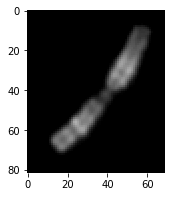

In [4]:
img1 = cv2.imread('chromosome_classif.bmp', cv2.IMREAD_GRAYSCALE)
show(img1)

In [5]:
# binarize the image using threshold analysis
# try THRESH_TRIANGLE, THRESH_BINARY_INV + cv2.THRESH_OTSU
# create binary mask from negative image here:
ret, img1_bw = cv2.threshold(255 - img1, 128, 255, cv2.THRESH_TRIANGLE)
img1_bw.shape
# here THRESH_TRIANGLE works usable

(82, 69)

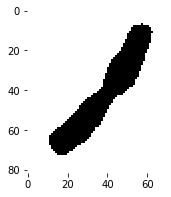

In [6]:
show(img1_bw)

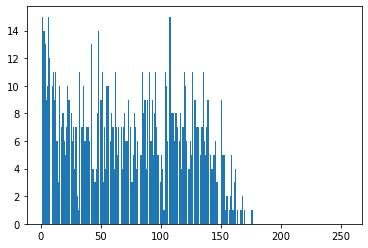

In [7]:
# show histogram of intensities
plt.hist(img1.ravel(),256,[1,255], cumulative=False)
plt.show()

In [8]:
# this image looks a little bit different
img2 = cv2.imread('chromosome_classif3.bmp', cv2.IMREAD_GRAYSCALE)

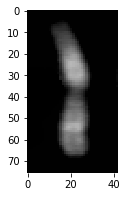

In [9]:
show(img2)

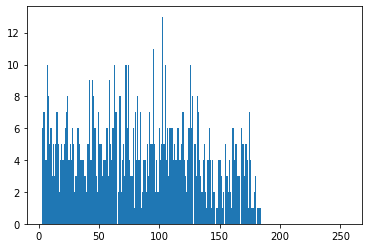

In [10]:
# show histogram of intensities
# ignore black backgroud (use intensity < 4)
plt.hist(img2.ravel(),256,[3,255], cumulative=False)
plt.show()

In [11]:
# for thresholding we should use negative image
img2_inverted = 255 - img2

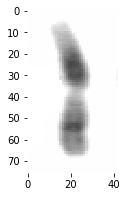

In [12]:
show(img2_inverted)

In [13]:
# binarize the image using threshold analysis
ret, img2_bw = cv2.threshold(img2_inverted, 128, 255, cv2.THRESH_TRIANGLE)
img2_bw.shape

(76, 42)

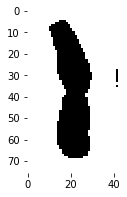

In [14]:
show(img2_bw)

In [15]:
# the function computes an angle to rotate the object to be vertically oriented
# mechanical momentums are used (some physics is needed)
def get_object_deviation(img_gray, background_gray_color):
    (h, w) = img_gray.shape[:2]
    
    # target deviation
    alpha = 0
    
    # mechanical moments
    m00 = 0.0   # area
    m10 = 0.0   # linear. momentums
    m01 = 0.0
    m20 = 0.0   # kvadrat. momentums
    m02 = 0.0
    m11 = 0.0   # deviation momentum
    cm20 = 0.0  # central momentum
    pm20 = 0.0  # principal quadratic momentums
    cm02 = 0.0
    cm11 = 0.0  # central deviation momentums

    #print ('w:', w, 'h:', h)
    
    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0
                y_1 = y + 1.0
                
                m00 += 1.0;
                m10 += x_1;
                m01 += y_1;
                m11 += x_1 * y_1;
                m02 += y_1 * y_1;
                m20 += x_1 * x_1;
                
    #print ('m00:', m00, 'm10:', m10, 'm01:', m01, 'm20:', m20, 'm02:', m02)

    if m00 == 0.0: # nothing to count
        #print ('m00==0')
        return alpha;     

    xc = m01 / m00;       # center of gravity
    yc = m10 / m00;
    
    #print ('xc:', xc, 'yc:', yc)

    for x in range(w):
        for y in range(h):
            v = img_gray[y, x]
            if v != background_gray_color:
                x_1 = x + 1.0 - xc
                y_1 = y + 1.0 - yc;
                cm02 += y_1 * y_1;
                cm20 += x_1 * x_1;
                cm11 += x_1 * y_1;

    # princial quadratic momentums are the same as momentums moved to the center of gravity (Steiner's theorem)
    # in the center of gravity the linear momentums are zero
    cm11 = m11 - xc*yc*m00;
    #print ('cm11:', cm11)

    # symetric object
    if cm20 == cm02:
        #print ('cm20 == cm02')
        return alpha

    # symetric object in one axis
    if cm11 == 0.0 and cm20 > cm02:
        #print ('cm11 == 0.0 and cm20 > cm02')
        alpha = 3.141593
        return alpha

    # symetric object in another axis
    if cm11 == 0.0:
        #print ('cm11 == 0.0')
        return alpha

    alpha = 0.5 * math.atan2(2.0 * cm11, (cm20 - cm02)) # = atan(y/x)

    # adjust angle
    alpha = 1.5707963 - alpha
    return alpha

In [16]:
# adapted from imutils.rotate_bound - use white background as default
def rotate_image(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    # white background
    dst = np.full((nH, nW), 255, np.float)

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), dst=dst, borderMode=cv2.BORDER_TRANSPARENT)

In [17]:
def crop_image(img_gray, background_gray_color):
    """
    Takes gray image and returns cropped image.
    """
    (h, w) = img_gray.shape[:2]
    x1 = w - 1
    y1 = h - 1
    x2 = 0
    y2 = 0
    
    for x in range(w):
        for y in range(h):
            color = img_gray[y,x]
            if color != background_gray_color:                               
                if x < x1:
                    x1 = x
                if x > x2:
                    x2 = x
                if y < y1:
                    y1 = y
                if y > y2:
                    y2 = y
    
    cropped = img_gray[y1 : y2+1, x1 : x2+1]
    return cropped

In [18]:
def prepare_image_for_seed_fill(img_bw):
    """
    Prepare binary image - 0 is background, 1 is object.
    """
    img_bw_dest = np.where(img_bw == 0, 1, 0).astype(int)
    return img_bw_dest


def find_objects_using_seed_fill(img_bw):
    """
    Detect objects from binary thresholded image using seed filling.
    """
    (h, w) = img_bw.shape[:2]
    # avoid recursion algorithm, which causes stack overflow for large objects,
    # use limited stack to explore pixel space
    stack_array = np.ndarray((30000,),int)
    # start with 2, 0 is background, 1 are thresholded objects, >=2 will be detected objects
    fill_color = 2
    
    for y in range(1, h-1):
        for x in range(1, w-1):
            color = img_bw[y, x]
            if color == 1: # this is new objects
                result = _seed_fill(img_bw, x, y, w, h, fill_color, stack_array)
                if result:
                    # prepare next color
                    fill_color += 1
                
    # number of detected objects
    return fill_color - 2


def _seed_fill(img_bw, x, y, w, h, fill_color, stack_array):
    """
    4-connected seed/flood fill algorithm avoiding recursion due to stack limit.
    """
    # index to the stack with x or y coordinates
    top_of_stack = -1;
    max_top_of_stack = len(stack_array) - 8
    color = 0
    
    while True:
        if x > 0 and x < w-1 and y > 0 and y < h-1:
            color = img_bw[y, x]
        else:
            color = 0 # black to ignore processing
            
        if color == 1: 
            # if not marked object pixel, then color the pixel with fill color
            # and continue with seed fill to 4 directions
            img_bw[y, x] = fill_color
            
            # search pixel neighbors
            if top_of_stack < max_top_of_stack:
                # push to stack - left
                top_of_stack += 1; stack_array[top_of_stack] = x+1
                top_of_stack += 1; stack_array[top_of_stack] = y
                # push to stack - right
                top_of_stack += 1; stack_array[top_of_stack] = x-1
                top_of_stack += 1; stack_array[top_of_stack] = y
                # push to stack - bottom
                top_of_stack += 1; stack_array[top_of_stack] = x
                top_of_stack += 1; stack_array[top_of_stack] = y+1          
                # push to stack - top
                top_of_stack += 1; stack_array[top_of_stack] = x
                top_of_stack += 1; stack_array[top_of_stack] = y-1
            else:
                print ('Too large object detected, finish.')
                return False

        if top_of_stack == -1:
            break
        else:
            # process stack
            y = stack_array[top_of_stack]; top_of_stack -= 1
            x = stack_array[top_of_stack]; top_of_stack -= 1

    return True


def find_objects_after_seed_fill(img_bw_seed):
    """
    Find rectangular boundaries of objects found by seed fill.
    """
    # key is color, value is map of x1,y1,x2,y2
    found_objects = {}
    
    (h, w) = img_bw_seed.shape[:2]
    
    for y in range(0, h):
        for x in range(0, w):
            color = img_bw_seed[y, x]
            if color == 0 or color == 1:
                continue
            
            obj = found_objects[color] if color in found_objects else None
            if obj is None:
                obj = {'x1' : x, 'x2' : x, 'y1' : y, 'y2' : y}
                found_objects[color] = obj
            else:
                x1 = obj['x1']
                x2 = obj['x2']
                y1 = obj['y1']
                y2 = obj['y2']
                
                if x < x1:
                    obj['x1'] = x
                if x > x2:
                    obj['x2'] = x
                if y < y1:
                    obj['y1'] = y
                if y > y2:
                    obj['y2'] = y
                    
    #print ('found_objects:', found_objects)
                    
    return found_objects                                      


def extract_objects_after_seed_fill(found_objects, img_bw_seed, img_gray):
    """
    Extract images of object found by seed fill.
    """
    detected_images = []
    
    for fill_color, coords in found_objects.items():
        x1 = coords['x1']
        x2 = coords['x2']
        y1 = coords['y1']
        y2 = coords['y2']
        w = x2 - x1
        h = y2 - y1
        
        area = w*h
        #print ('area:', area)
        
        # ignore small objects
        if area < 100:
            continue
            
        new_img = np.full((h,w), 255, np.float)
        detected_images.append(new_img)
        
        for x in range(x1, x2):
            for y in range(y1, y2):
                color = img_bw_seed[y,x]
                if color != fill_color:
                    continue
                new_img[y - y1,x - x1] = img_gray[y,x]
    
    return detected_images


def extract_objects(img_gray, img_bw):
    """
    Extract images of objects from gray image using thresholded image as binary mask.
    """
    img_bw_seed = prepare_image_for_seed_fill(img_bw)
    
    n_objects = find_objects_using_seed_fill(img_bw_seed)
    # print('Found:', n_objects)
    if n_objects == 0:
        raise('No object detected')

    found_objects = find_objects_after_seed_fill(img_bw_seed)
    extracted_images = extract_objects_after_seed_fill(found_objects, img_bw_seed, img_gray)
    return extracted_images

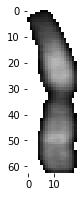

In [19]:
img2_extracted = extract_objects(img2, img2_bw)
show_binary(img2_extracted[0])

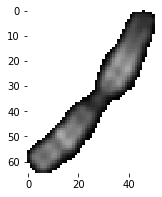

In [20]:
img1_extracted = extract_objects(img1, img1_bw)
show_binary(img1_extracted[0])

In [21]:
def get_vert_rotated_image(img_gray):
    """
    Find object deviation using mechanical momentums and rotate image. Enhance edges using erosion.
    """
    alpha = get_object_deviation(img_gray, 255)
    alpha_degrees = 180.0*alpha/math.pi
    rotated_img = rotate_image(img_gray, alpha_degrees)
    # erosion - trim border and garbage after rotating
    kernel = np.ones((2, 2), np.uint8)
    rotated_img = cv2.erode(rotated_img, kernel, cv2.BORDER_REFLECT)  
    cropped_img = crop_image(rotated_img, 255)
    return cropped_img

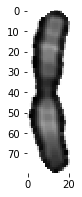

In [22]:
# rotate chromosome to vertical orientation
img1_normalized = get_vert_rotated_image(img1_extracted[0])
show_binary(img1_normalized)

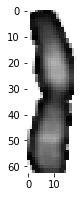

In [23]:
## rotate chromosome to vertical orientation
img2_normalized = get_vert_rotated_image(img2_extracted[0])
show_binary(img2_normalized)

In [24]:
# load all images and perform the preprocessing
def load_chromosomes_in_classes(root_dir, is_train_set):
    """
    Return mapping with class ID as key of type string -> list of image bytes.
    For train set, create new images using flipping
    """
    chromosomes_classes = {}
    
    for class_dir in os.listdir(root_dir):
        class_name = os.path.basename(class_dir)
        
        img_list = []
        chromosomes_classes[class_name] = img_list
        
        for chrom_file in os.listdir(os.path.join(root_dir, class_dir)):
            chrom_file_abs = os.path.abspath(os.path.join(root_dir, class_dir, chrom_file))           
            img_chrom = cv2.imread(chrom_file_abs, cv2.IMREAD_GRAYSCALE)
            
            ret, img_bw_mask = cv2.threshold(255 - img_chrom, 128, 255, cv2.THRESH_TRIANGLE)            
            img_extracted_list = extract_objects(img_chrom, img_bw_mask)
            
            if len(img_extracted_list) == 0:
                print ('ERROR: No object found:', chrom_file_abs, len(img_extracted_list))
            else:
                img_extracted = img_extracted_list[0]
                #print ('img_extracted:', img_extracted)
                img_vertical = get_vert_rotated_image(img_extracted)
                img_list.append({'file' : chrom_file, 'data' : img_vertical})
                area = img_vertical.shape[0] * img_vertical.shape[1]
                
                # append flipped images
                if is_train_set:
                    img_list.append({'file' : chrom_file, 'data' : cv2.flip(img_vertical, 0)})
                    img_list.append({'file' : chrom_file, 'data' : cv2.flip(img_vertical, 1)})
                    img_list.append({'file' : chrom_file, 'data' : cv2.flip(img_vertical, -1)})
            
    return chromosomes_classes

In [25]:
print ('Loading images...')
chromosomes_labeled_train = load_chromosomes_in_classes(os.path.join('classificationDB', 'Train'), True)
chromosomes_labeled_test = load_chromosomes_in_classes(os.path.join('classificationDB', 'Test'), False)
chromosomes_labeled_val = load_chromosomes_in_classes(os.path.join('classificationDB', 'Val'), False)
print('Done.')

Loading images...
Done.


In [26]:
#print (len(chromosomes_labeled_train))
#print (len(chromosomes_labeled_test))
#print (len(chromosomes_labeled_val))
#imgs = chromosomes_labeled_train['1']
#for i in range(100):
#    print (imgs[i]['file'])
#    show_binary(imgs[i]['data'])

In [27]:
# get dimension distributions
width_list = []
height_list = []

def detect_dimensions(chromosomes_labeled, width_list, height_list):
    for chrom_list in chromosomes_labeled.values():
        for chrom in chrom_list:
            data = chrom['data']
            if data is None:
                continue
            (h, w) = data.shape[:2]
            width_list.append(w)
            height_list.append(h)
            
            #if w > 50:
            #    show_binary(data)

detect_dimensions(chromosomes_labeled_train, width_list, height_list)
detect_dimensions(chromosomes_labeled_test, width_list, height_list)
detect_dimensions(chromosomes_labeled_val, width_list, height_list)

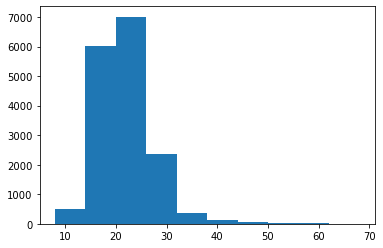

In [28]:
# What are typical dimensions for image widths and heights?
plt.hist(width_list)
plt.show()

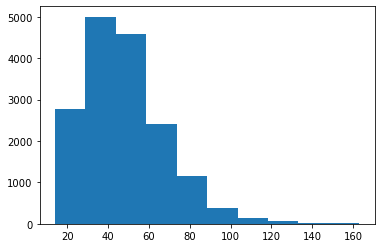

In [29]:
plt.hist(height_list)
plt.show()

In [30]:
# select image dimensions
max_width = 40
max_height = 160

# number of paired chromosomes as class IDs
n_classes = 23

# convert image into input vector
def convert_image_to_vector(chrom_data, dest_vector_data):
    (h, w) = chrom_data.shape[:2]
    (h_dest, w_dest) = dest_vector_data.shape[:2]
    
    for x in range(w):
        for y in range(h):
            # ignore bigger image
            if x >= w_dest or y >= h_dest:
                continue
            # scale image to [0, 1]
            dest_vector_data[y, x] = chrom_data[y, x] / 255.0

            
def convert_class_to_category(class_id):
    y = []
    
    for i in range(n_classes):
        y.append(1 if class_id == str(i) else 0)
        
    return np.asarray(y, dtype=np.float)
    

def prepare_dataset(chromosomes_labeled, max_width, max_height):
    X = []
    y = []
    
    for class_id, chrom_list in chromosomes_labeled.items():
        for chrom in chrom_list:
            chrom_data = chrom['data']
                   
            # fill with 1 - white color 255 scaled to value 1
            dest_vector_data = np.full((max_height, max_width), 1, dtype=np.float)
            convert_image_to_vector(chrom_data, dest_vector_data)
            X.append(np.reshape(dest_vector_data, ((max_height, max_width, 1))))            
            categories = convert_class_to_category(class_id)
            y.append(categories)
        
    return np.asarray(X), np.asarray(y)

In [31]:
X_train, y_train = prepare_dataset(chromosomes_labeled_train, max_width, max_height)
X_test, y_test = prepare_dataset(chromosomes_labeled_test, max_width, max_height)
X_val, y_val = prepare_dataset(chromosomes_labeled_val, max_width, max_height)

print ('X_train:', X_train.shape)
print ('y_train:', y_train.shape)
print ('X_test:', X_test.shape)
print ('y_test:', y_test.shape)
print ('X_val:', X_val.shape)
print ('y_val:', y_val.shape)

X_train: (14720, 160, 40, 1)
y_train: (14720, 23)
X_test: (920, 160, 40, 1)
y_test: (920, 23)
X_val: (874, 160, 40, 1)
y_val: (874, 23)


In [47]:
# Keras (from TensorFlow) imports for the dataset and building NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# learn using CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(max_height, max_width, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(max_height, max_width, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 158, 38, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 79, 19, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 79, 19, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 77, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 38, 8, 32)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 38, 8, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9728)             

In [48]:
# compiling the sequential model
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='adam'
)

In [51]:
# use e.g. 100 epochs
epochs = 30
batch_size = 128

# training the model and saving metrics in history
history = model.fit(
    X_train, 
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data=(X_val, y_val))

Train on 14720 samples, validate on 874 samples
Epoch 1/30
14720/14720 [==============================] - 64s 4ms/sample - loss: 0.7073 - accuracy: 0.7304 - val_loss: 1.4382 - val_accuracy: 0.5240
Epoch 2/30
14720/14720 [==============================] - 66s 4ms/sample - loss: 0.6929 - accuracy: 0.7368 - val_loss: 1.4268 - val_accuracy: 0.5217
Epoch 3/30
14720/14720 [==============================] - 66s 5ms/sample - loss: 0.6819 - accuracy: 0.7399 - val_loss: 1.4475 - val_accuracy: 0.5183
Epoch 4/30
14720/14720 [==============================] - 71s 5ms/sample - loss: 0.6670 - accuracy: 0.7459 - val_loss: 1.4214 - val_accuracy: 0.5172
Epoch 5/30
14720/14720 [==============================] - 74s 5ms/sample - loss: 0.6537 - accuracy: 0.7497 - val_loss: 1.4226 - val_accuracy: 0.5423
Epoch 6/30
14720/14720 [==============================] - 65s 4ms/sample - loss: 0.6457 - accuracy: 0.7541 - val_loss: 1.4606 - val_accuracy: 0.5355
Epoch 7/30
14720/14720 [==============================] - 

In [52]:
def plot_model_history(model_history):
    history_dict = model_history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'b', label='Training loss', color='blue')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='yellow')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

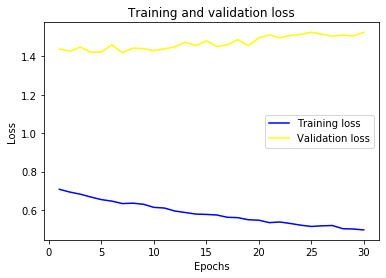

In [53]:
plot_model_history(history)

In [58]:
# Evaluate testing data loss and accuracy
loss = model.evaluate(X_test, y_test, verbose=0)

In [59]:
model.metrics_names

['loss', 'accuracy']

In [60]:
loss

[1.31489170945209, 0.6054348]

In [61]:
# Training and validation data:
# loss: 0.4958 - accuracy: 0.8005 - val_loss: 1.5253 - val_accuracy: 0.5618